# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [11]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2019-10-12 12:05:40--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2019-10-12 12:05:40--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [18]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, scheduler_loss=False):    
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        train_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        
        val_loss, val_accuracy = compute_loss_accuracy(model, val_loader)
        
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        
        print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

  
def compute_loss_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    loss_accum = 0.0
    correct = 0.0
    total = 0.0
    for i, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        y_probs = model(x_gpu)        
        y_hat = torch.argmax(y_probs, 1)
        
        loss_value = loss(y_probs, y_gpu)
        loss_accum += float(loss_value)
        
        correct += float(torch.sum(y_hat == y_gpu))
        total += y_gpu.shape[0]
        
    return loss_accum / (i + 1), correct / total

    
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch #0 - train loss: 1.355734, accuracy: 0.551360 | val loss: 0.902269, accuracy: 0.712170
Epoch #1 - train loss: 0.695037, accuracy: 0.788998 | val loss: 0.626688, accuracy: 0.809911
Epoch #2 - train loss: 0.593727, accuracy: 0.822749 | val loss: 0.604554, accuracy: 0.818238
Epoch #3 - train loss: 0.546115, accuracy: 0.836228 | val loss: 0.603891, accuracy: 0.817896
Epoch #4 - train loss: 0.510609, accuracy: 0.847644 | val loss: 0.539888, accuracy: 0.842468
CPU times: user 1min 57s, sys: 14.4 s, total: 2min 12s
Wall time: 2min 12s


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

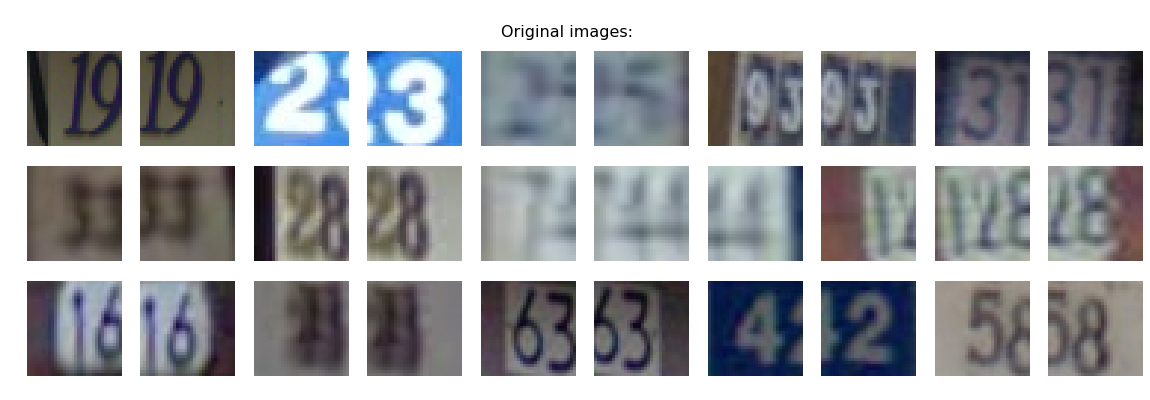

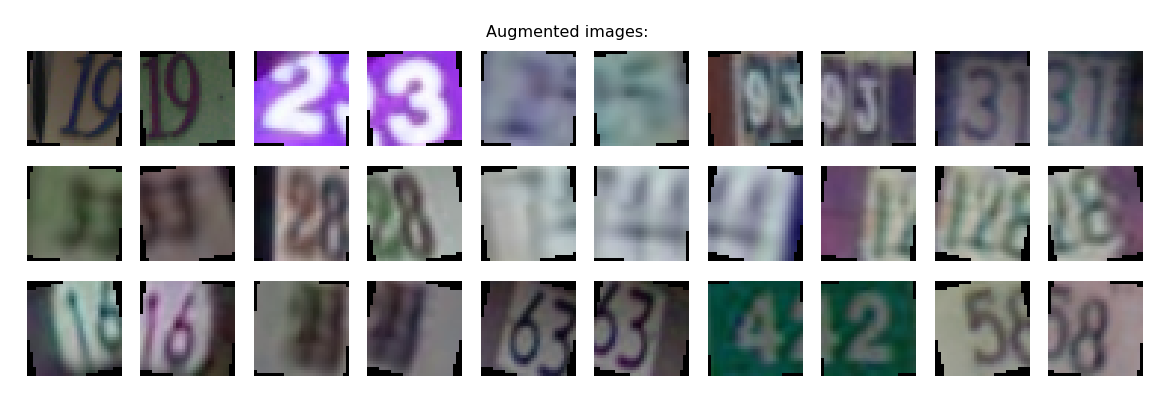

In [20]:
# Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

rows = 3
cols = 10

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nOriginal images:', fontsize=16)

for i, (x, y) in enumerate(dset.SVHN('./')):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')


# -----------------------------------------------------------------
    
    
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15, resample=PIL.Image.BILINEAR)
])        
data_aug_vis = dset.SVHN('./', transform=tfs)

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nAugmented images:', fontsize=16)

for i, (x, y) in enumerate(data_aug_vis):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [22]:
# Finally, let's train with augmentations!
# Note we shouldn't use augmentations on validation

%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch #0 - train loss: 0.600321, accuracy: 0.816794 | val loss: 0.556131, accuracy: 0.834482
Epoch #1 - train loss: 0.548547, accuracy: 0.833072 | val loss: 0.521204, accuracy: 0.846086
Epoch #2 - train loss: 0.531235, accuracy: 0.838532 | val loss: 0.488633, accuracy: 0.854140
Epoch #3 - train loss: 0.516899, accuracy: 0.844504 | val loss: 0.484559, accuracy: 0.858098
Epoch #4 - train loss: 0.500348, accuracy: 0.847985 | val loss: 0.478261, accuracy: 0.857825
CPU times: user 4min 4s, sys: 13.2 s, total: 4min 18s
Wall time: 4min 18s


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
# Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    # C1
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
    nn.Tanh(),
    
    # S2
    nn.MaxPool2d(kernel_size=2),
    
    # C3
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.Tanh(),
    
    # S4
    nn.MaxPool2d(kernel_size=2),
    
    Flattener(),

    # F5
    nn.Linear(in_features=5*5*16, out_features=120),
    nn.Tanh(),
    
    # F6
    nn.Linear(in_features=120, out_features=84),
    nn.Tanh(),
    
    # O7
    nn.Linear(in_features=84, out_features=10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [24]:
# Let's train it!
%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Epoch #0 - train loss: 1.308671, accuracy: 0.557161 | val loss: 0.588275, accuracy: 0.819603
Epoch #1 - train loss: 0.574315, accuracy: 0.824864 | val loss: 0.491160, accuracy: 0.849703
Epoch #2 - train loss: 0.496520, accuracy: 0.847814 | val loss: 0.501150, accuracy: 0.843560
Epoch #3 - train loss: 0.451752, accuracy: 0.860339 | val loss: 0.420855, accuracy: 0.872295
Epoch #4 - train loss: 0.423087, accuracy: 0.871276 | val loss: 0.408766, accuracy: 0.876391
Epoch #5 - train loss: 0.402471, accuracy: 0.876344 | val loss: 0.410654, accuracy: 0.875230
Epoch #6 - train loss: 0.384851, accuracy: 0.882367 | val loss: 0.407428, accuracy: 0.875913
Epoch #7 - train loss: 0.366440, accuracy: 0.888220 | val loss: 0.369289, accuracy: 0.887857
Epoch #8 - train loss: 0.354883, accuracy: 0.890574 | val loss: 0.392536, accuracy: 0.880827
Epoch #9 - train loss: 0.341281, accuracy: 0.895130 | val loss: 0.385177, accuracy: 0.885605
CPU times: user 7min 40s, sys: 5.06 s, total: 7min 45s
Wall time: 7min

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

# Подбор гиперпараметров

In [25]:
model = nn.Sequential(
    # 32x32@3 => 32x32@16
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(inplace=True),    
    
    # 32x32@16 => 16x16@16
    nn.MaxPool2d(kernel_size=2),
    
    # 16x16@16 => 14x14@32
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(inplace=True),    
    
    # 14x14@32 => 7x7@32
    nn.MaxPool2d(kernel_size=2),
    
    # 7x7@32 => 5x5@64
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    
    Flattener(),

    nn.Linear(in_features=5*5*64, out_features=128),    
    nn.BatchNorm1d(num_features=128),
    nn.ReLU(inplace=True),
    
    nn.Linear(in_features=128, out_features=10)
)

model.type(torch.cuda.FloatTensor)
model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

%time train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, train_aug_loader, val_loader, loss, optimizer, 10, \
                                                                                             scheduler=scheduler, scheduler_loss=True)

Epoch #0 - train loss: 0.640532, accuracy: 0.803058 | val loss: 0.390802, accuracy: 0.883626
Epoch #1 - train loss: 0.390913, accuracy: 0.882128 | val loss: 0.332090, accuracy: 0.899188
Epoch #2 - train loss: 0.341951, accuracy: 0.897843 | val loss: 0.312100, accuracy: 0.906832
Epoch #3 - train loss: 0.319555, accuracy: 0.902774 | val loss: 0.313645, accuracy: 0.905672
Epoch #4 - train loss: 0.303991, accuracy: 0.909770 | val loss: 0.287571, accuracy: 0.913043
Epoch #5 - train loss: 0.291799, accuracy: 0.913200 | val loss: 0.283191, accuracy: 0.916388
Epoch #6 - train loss: 0.282532, accuracy: 0.915418 | val loss: 0.276463, accuracy: 0.920415
Epoch #7 - train loss: 0.277374, accuracy: 0.917090 | val loss: 0.284926, accuracy: 0.916183
Epoch #8 - train loss: 0.272345, accuracy: 0.919974 | val loss: 0.278442, accuracy: 0.918231
Epoch #9 - train loss: 0.268133, accuracy: 0.920861 | val loss: 0.274184, accuracy: 0.919528
CPU times: user 8min 33s, sys: 10 s, total: 8min 43s
Wall time: 8min 4

In [0]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

HyperParams = namedtuple("Hyperparams", ['learning_rate', 'reg_strength', 'anneal_factor', 'anneal_patience', 'epochs'])
RunResult = namedtuple("RunResult", ['model', 'train_loss_history', 'train_acc_history', 'val_loss_history', 'val_acc_history', 'final_val_accuracy'])

def search(stats, learning_rates, reg_strengths, anneal_factor=0.333, anneal_patience=3, epochs=15):            
    for learning_rate in learning_rates:
        for reg_strength in reg_strengths:            
            
            model = nn.Sequential(
                # 32x32@3 => 32x32@16
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=16),
                nn.ReLU(inplace=True),    

                # 32x32@16 => 16x16@16
                nn.MaxPool2d(kernel_size=2),

                # 16x16@16 => 14x14@32
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.BatchNorm2d(num_features=32),
                nn.ReLU(inplace=True),    

                # 14x14@32 => 7x7@32
                nn.MaxPool2d(kernel_size=2),

                # 7x7@32 => 5x5@64
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(inplace=True),

                Flattener(),

                nn.Linear(in_features=5*5*64, out_features=128),    
                nn.BatchNorm1d(num_features=128),
                nn.ReLU(inplace=True),

                nn.Linear(in_features=128, out_features=10)
            )
    
            model.type(torch.cuda.FloatTensor)
            model.to(device)

            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=anneal_factor, patience=anneal_patience, verbose=True)
            
            key = HyperParams(learning_rate, reg_strength, anneal_factor, anneal_patience, epochs)
            
            print('Training model: %s' % str(key))
            
            results = train_model(model, train_aug_loader, val_loader, loss, optimizer, epochs, scheduler=scheduler, scheduler_loss=True)
            train_loss_history, train_acc_history, val_loss_history, val_acc_history = results
            final_val_accuracy = val_acc_history[-1]
                                    
            value = RunResult(model, train_loss_history, train_acc_history, val_loss_history, val_acc_history, final_val_accuracy)            
            stats[key] = value
            
            print('\n')
    

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

In [27]:
learning_rates = [1e-3]
reg_strengths = [1e-4]

search(run_record, learning_rates, reg_strengths, epochs=20)

Training model: Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20)
Epoch #0 - train loss: 0.623288, accuracy: 0.808910 | val loss: 0.376855, accuracy: 0.884308
Epoch #1 - train loss: 0.378166, accuracy: 0.884739 | val loss: 0.321350, accuracy: 0.900826
Epoch #2 - train loss: 0.318548, accuracy: 0.903696 | val loss: 0.311242, accuracy: 0.905808
Epoch #3 - train loss: 0.282002, accuracy: 0.915179 | val loss: 0.281957, accuracy: 0.917548
Epoch #4 - train loss: 0.256844, accuracy: 0.923455 | val loss: 0.287205, accuracy: 0.914204
Epoch #5 - train loss: 0.237785, accuracy: 0.928181 | val loss: 0.260653, accuracy: 0.923077
Epoch #6 - train loss: 0.217082, accuracy: 0.932959 | val loss: 0.269327, accuracy: 0.921780
Epoch #7 - train loss: 0.204553, accuracy: 0.938419 | val loss: 0.269908, accuracy: 0.920688
Epoch #8 - train loss: 0.191018, accuracy: 0.941508 | val loss: 0.274482, accuracy: 0.920278
Epoch     9: reducing learning rate of gro

In [28]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

best_model = run_record[best_hyperparams].model

Best validation accuracy: 0.929902, best hyperparams: Hyperparams(learning_rate=0.001, reg_strength=0.0001, anneal_factor=0.333, anneal_patience=3, epochs=20)


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [29]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(best_model, test_loader)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.269881, accuracy: 0.930124
